<a href="https://colab.research.google.com/github/acse-moj20/msc-irp/blob/dev/DCGAN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorials for CSE Independent Research Project
- Mustapha Jolaade (moj20@ic.ac.uk)

Setup and Packages Import

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os 
import PIL 
from tensorflow.keras import layers
import time
from IPython import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print("Num of available GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num of available GPUs:  0


# Deep Convolutional Generative Adversarial Network Using Tensorflow
- This tutorial shows to generate images of handwritten digits between 0 and 9 from MNIST dataset using a DC-GAN.

- Mustapha Jolaade (moj20@ic.ac.uk)

The idea behind GAN is to train two models simultaneously using an adversarial process. One of the models, a generator, learns to create images/predictiosn that look real while the other, a discriminator, learns to tell real images/predictions apart from fakes.

The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.



DC-GAN Tutorial Using MNIST dataset

####**Load and prepare dataset**

In [9]:
# Source data 
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5 

11493376/11490434 [==============================] - 0s 0us/step


####**Batch and shuffle the data**

[tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) is a tensorflow API for writing input pipelines (i.e. data input for model).

The `from_tensor_slices` method creates a `Dataset` type object whose elements are slices of the input tensor.

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

####**Explore and visualize the data**

<class 'numpy.ndarray'>
(60000, 28, 28, 1)


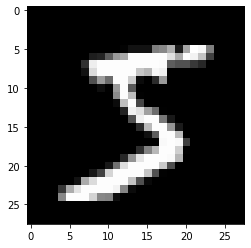

In [24]:
print(type(train_images))
print(train_images.shape)
plt.imshow(train_images[0, :, :, 0], cmap='gray');

####**Create the models**

The generator and discriminator model can be created using the Keras Sequential. API

The generator uses `tf.keras.layers.Conv2DTranspose` layers for upsampling and to produce images from random noise seed. The activation for each layer is a LeakyRELU except the output layer that uses a tanh activation.

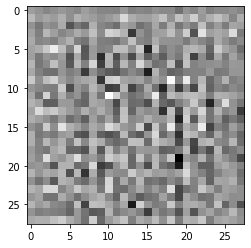

In [25]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  # note: None is the batch size
  assert model.output_shape == (None, 7, 7, 256)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

# Use the untrained generator model
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray');


The discrimimantor is a CNN-based image classifier also build using Keras Sequential. I then use the (yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images and negative values for fake images.

In [28]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.0009633]], shape=(1, 1), dtype=float32)


####**Define the loss and optimizers**

We need to define the loss functions and optimizers for both models. The in-built `keras.losses.BinaryCrossentropy()` method helps compute cross entropy loss. 

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator Loss

---
This loss function will quantify how well the discriminator is able to distinguish real images from fakes. It performs a comparison between the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

Generator Loss

---
The generator loss quanitifies how well it is able to trick the discriminator so if it is performing well, the dicriminator will classify fake images as real(or 1). 

This means we compare the discirminator's decisions on the generated images (`fake_output`) to an array of 1s, as if it were real.

In [30]:
# generator loss is quantified by how much it can trick the discriminator (i.e. fake output is close to 1s)
def generator_loss(fake_ouput):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [31]:
# Separate optimizers since this invovles training 2 networks
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

####**Save checkpoints**

Saving checkpoints can be helpful in case a long running training task is interrupted.


In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

####**Define the training loop**

The training loop begins with generator receiving random seed as input which is used to produce an image. The discriminatior is then used to classifiy the real images (drawn from the training set) and fake images (produced by the generator). 

The loss is then calculated for each of the models witht the gradients used to update the generator and discirminator.

In [33]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [34]:
# The tf.function annotation makes the function to be "compiled" - more performant and python-independent
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_disc, discriminator.trainable_variables))

In [35]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      trian_step(image_batch)
    
    # Produce images for the GIF in this same step
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

####**Generate and save images**

In [36]:
def generate_and_save_images(model, epoch, test_input):

  # Trainig is set to false so all layers run in inference mode (batchnorm)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

###**Train the model**

Call the `train()` method defined above to train the generator and discriminator simultaneously.  Note that it is important that the genrator and discirminator train at a similar rate and they do not overpower each other.



# Automatic Differentiation Using Tensorflow

This simply means backpropagating error from loss function through the generator of a GAN

### Computing gradients notes
- To perform an auntomatic differentiaiton, TF needs to know the order of operations for the forward pass so for the backward pass, it can traverse this list of operation to obtain a gradient.

- The operations are stored in the context of a [tf.GradientTape](https://www.tensorflow.org/guide/autodiff#gradient_tapes) API as variable "tape". Then, gradient can be computed using the reverse mode diffferentiation.

- The shape of output of gradient has same shape as source (when using the tf.GardientTape api).

**Example 1: Gradient Tape**

In [4]:
# declare variables/dictionary of variables
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype= tf.float32), name='b')
x = [[1., 2., 3.]]
my_vars = { 'w': w, 'b':b}

# create a tape that stores an order of operation using the tf.GradientTape API
with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

# Compute gradient of loss with respect to specific variable(s)
loss_grad = tape.gradient(loss, my_vars)
print(loss_grad['w'])
print(loss_grad['b'])

tf.Tensor(
[[  3.5941315  -5.6095257]
 [  7.188263  -11.219051 ]
 [ 10.782394  -16.828577 ]], shape=(3, 2), dtype=float32)
tf.Tensor([ 3.5941315 -5.6095257], shape=(2,), dtype=float32)


Note that gradient output has same shape as its corresponding independent variable.

**Example 2: Gradient with respect to a model**

In [5]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  y = layer(x) # Forward pass through model
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable parameter

grad = tape.gradient(loss, layer.trainable_variables)

In [6]:
for var, deriv in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {deriv.shape}')
del tape

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


**Example 3: Controlling what the tape watches**

The use of GradientTape.watch(var) helps to restrict the number of variables being watched by the gradient tape. 

The default bhavior is to watch all accessed varibale by the tape but this can be disabled. 

In [7]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0, y1 = tf.math.sin(x0), tf.nn.softplus(x1)
  y = y0 + y1
  dy = tf.reduce_sum(y)
grad = tape.gradient(dy, {'x0':x0, 'x1':x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'])
del tape

dy/dx0: None
dy/dx1: tf.Tensor(0.9999546, shape=(), dtype=float32)


Since `GradientTape.watch` was not called on x0, its derivative is not calculated. 

Finally, derivative of intermediate result (some calculated variable within tape) can also be computed.

Gradients of non-scalar (multiple) targets returns the sum of the gradients of each target. For element-wise calculation however, the gadient tape API returns the derivative of each element (see below)

Text(0.5, 0, 'x')

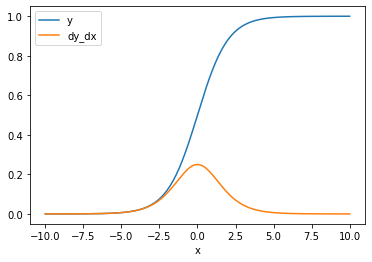

In [8]:
x = tf.linspace(-10.0, 10.0, 201)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)
grad = tape.gradient(y, x)
plt.plot(x, y, label='y')
plt.plot(x, grad, label='dy_dx')
plt.legend()
plt.xlabel('x')
